In [29]:
import pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from tqdm import trange
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")
from FCA import *

from SDL_src.SDL_BCD import SDL_BCD
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [128]:
X = pickle.load(open('./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_graph.pkl', 'rb'))
df_adj_nws = pd.DataFrame(X.T)
df_dynamics_nws = pd.read_csv("./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_FCA_dynamics_8kappa.csv")
df_g2v_nws = pd.read_csv("./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_graph2vec.csv")
df_n2v_nws = pd.read_csv("./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_node2vec.csv")
df_features_nws = pd.read_csv("./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_graph_features.csv")

In [129]:
X = pickle.load(open('./my_data/UCLA26_20walk/UCLA26_20walk_graph.pkl', 'rb'))
df_adj_ucla = pd.DataFrame(X.T)
df_dynamics_ucla = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_FCA_dynamics_8kappa.csv")
df_g2v_ucla = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_graph2vec.csv", header=None)
df_n2v_ucla = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_node2vec.csv", header=None)
df_features_ucla = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_graph_features.csv")

In [131]:
"""
print("edge mean:", np.mean(df_features.num_edges))
print("edge std:", np.std(df_features.num_edges))
print("diameter mean:", np.mean(df_features.diameter))
print("diameter std:", np.std(df_features.diameter))
print("===========y==========\n", df_dynamics.y.value_counts())
print("===========baseline_width==========\n", df_dynamics.baseline_width.value_counts())
"""

'\nprint("edge mean:", np.mean(df_features.num_edges))\nprint("edge std:", np.std(df_features.num_edges))\nprint("diameter mean:", np.mean(df_features.diameter))\nprint("diameter std:", np.std(df_features.diameter))\nprint("===========y==========\n", df_dynamics.y.value_counts())\nprint("===========baseline_width==========\n", df_dynamics.baseline_width.value_counts())\n'

## Dynamics

In [158]:
#df: dynamics + label
def sdl_plot(df, Y_data, filename):
    under_sampler = RandomUnderSampler(random_state=42)
    X_res, y_res = under_sampler.fit_resample(df, Y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                        test_size = 0.2, 
                                                        random_state = 4, 
                                                        stratify = y_res)

    xi = 1
    iter_avg = 1
    beta = 0.5
    iteration = 100
    r = 8
    SDL_BCD_class_new = SDL_BCD(X=[X_train.to_numpy().T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                            X_test=[X_test.to_numpy().T, y_test.to_numpy().reshape(-1,1).T],
                            #X_auxiliary = None,
                            n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                            # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            # ini_code = H_true,
                            xi=xi,  # weight on label reconstruction error
                            L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                            L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                            nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                            full_dim=False)

    results_dict_new = SDL_BCD_class_new.fit(iter=iteration, subsample_size=None,
                                                    beta = beta,
                                                    search_radius_const=np.linalg.norm(X_train),
                                                    update_nuance_param=False,
                                                    if_compute_recons_error=False, if_validate=False)



    ncol = 4
    nrow = 2
    fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
    sorted_indices = np.argsort(results_dict_new["loading"][1][0][1:])[::-1]
    for i in range(r):
        ind = sorted_indices[i]
        sns.heatmap(results_dict_new["loading"][0].T[ind].reshape(50, 20),
                    ax = axs[i//ncol, (i-4)%ncol])
        axs[i//ncol, (i-4)%ncol].title.set_text(str(results_dict_new["loading"][1][0][1:][sorted_indices[i]]))
    fig.savefig(filename)
    return results_dict_new

  2%|▏         | 2/100 [00:00<00:07, 12.66it/s]

initial loading beta [[ 0.08880486  0.00681943  0.5348778   0.30081457  0.27060698  0.47719803
   0.94757021 -0.96093693 -0.02406255]]


100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


!!! pred_type filter


  2%|▏         | 2/100 [00:00<00:08, 11.64it/s]

initial loading beta [[-0.92667593 -0.85931565  0.96662915  0.23070966  0.07951955  0.31583077
   0.67496916  0.21155063  0.95096624]]


100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


!!! pred_type filter


  1%|          | 1/100 [00:00<00:10,  9.05it/s]

initial loading beta [[ 0.35619088 -0.79431105  0.04617206  0.53290224  0.76350965  0.93217823
  -0.14285947 -0.36965369 -0.64617368]]


100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


!!! pred_type filter


  2%|▏         | 2/100 [00:00<00:07, 13.24it/s]

initial loading beta [[-0.21346884 -0.95662571 -0.25244957  0.68250282  0.8965176   0.2234213
  -0.62843517  0.59756266 -0.4952264 ]]


100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


!!! pred_type filter


  2%|▏         | 2/100 [00:00<00:08, 11.92it/s]

initial loading beta [[-0.84441343  0.11484724  0.09380812  0.38026073  0.59840271  0.05875177
   0.03935067  0.23120939 -0.75074616]]


100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


!!! pred_type filter


  2%|▏         | 2/100 [00:00<00:07, 12.81it/s]

initial loading beta [[-0.29468135 -0.59679936  0.96376946  0.78559727 -0.30678607  0.3001591
   0.84582084 -0.53493037  0.07780912]]


100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


!!! pred_type filter


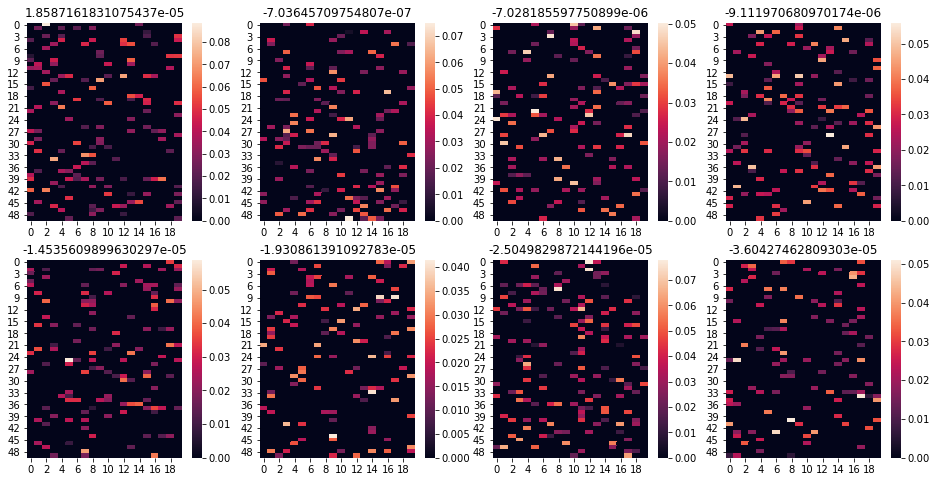

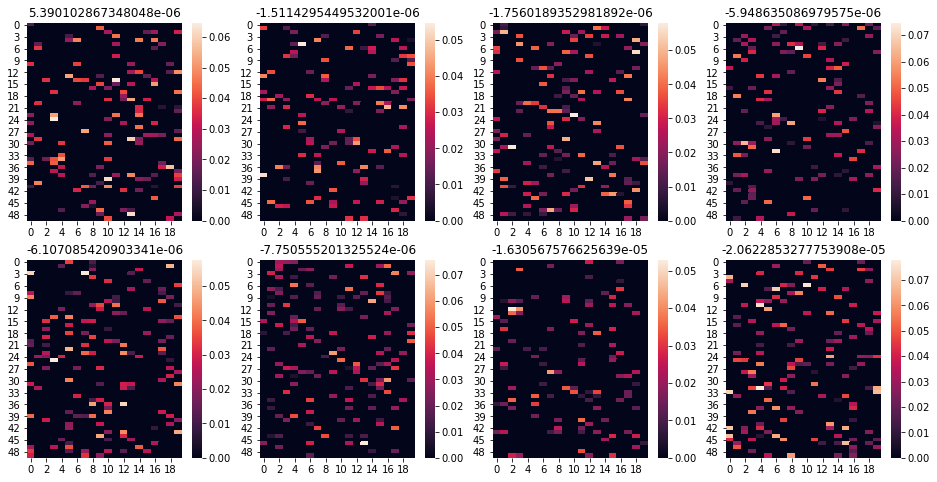

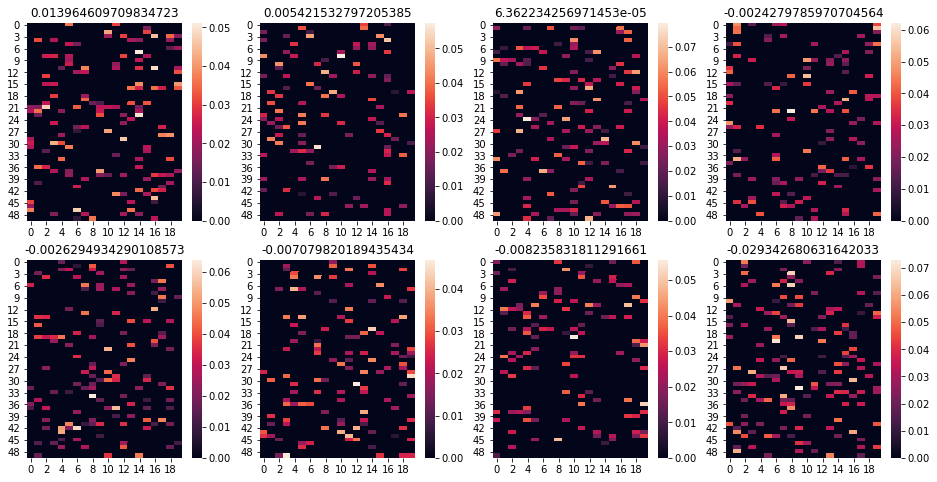

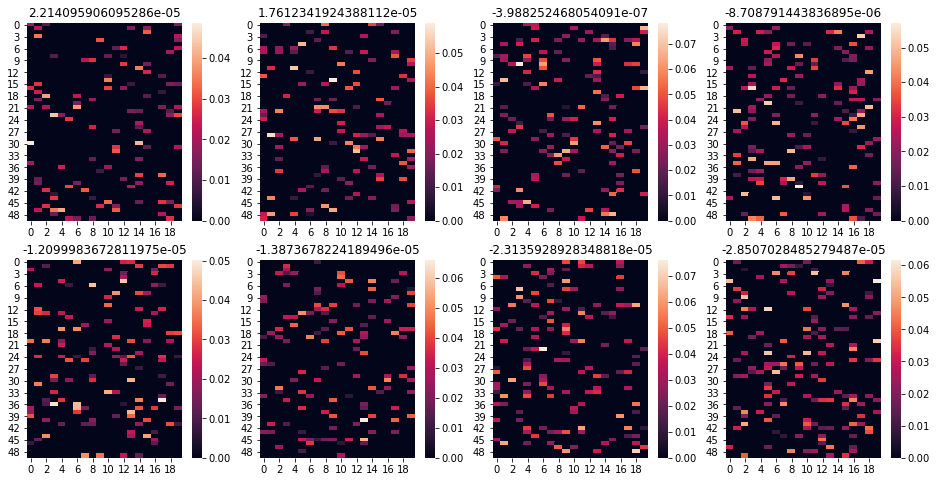

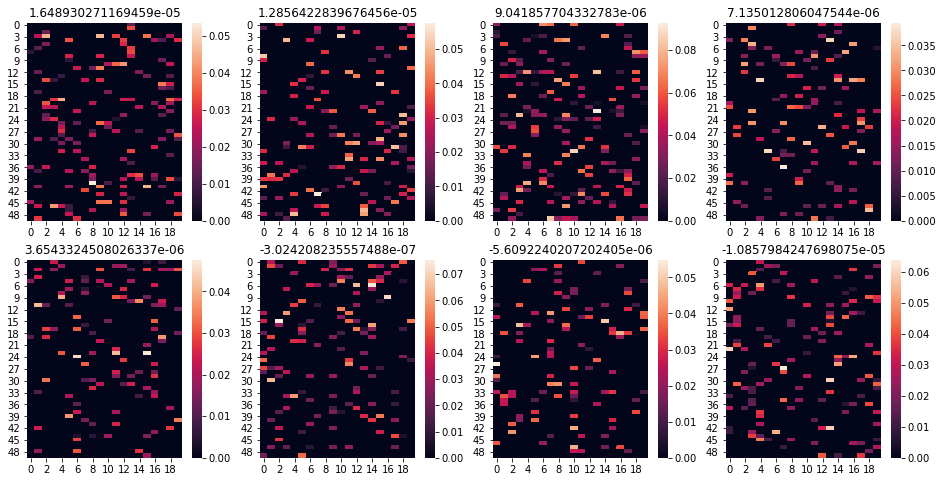

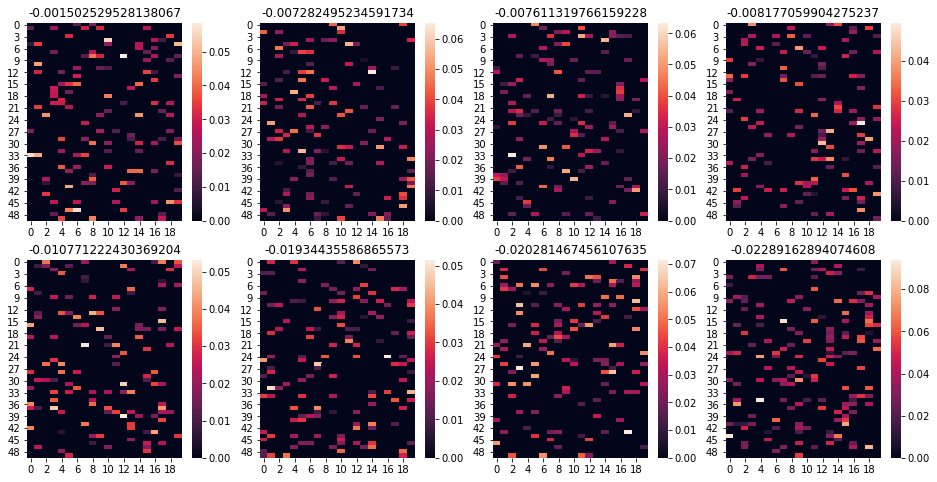

In [248]:
df = pd.concat([df_dynamics_ucla[df_dynamics_ucla.baseline_width == True], 
          df_dynamics_ucla[df_dynamics_ucla.y == False]], axis=0).copy()
Y_data = df.y
df = df.loc[:, 's1_1':'s50_20']
df = df/np.linalg.norm(df)
dict_ucla1 = sdl_plot(df, Y_data, "temp.jpg")

df = df_dynamics_ucla.copy()
Y_data = df.y
df = df.loc[:, 's1_1':'s50_20']
df = df/np.linalg.norm(df)
dict_ucla2 = sdl_plot(df, Y_data, "temp.jpg")

df = pd.concat([df_dynamics_ucla[df_dynamics_ucla.baseline_width == True], 
          df_dynamics_ucla[df_dynamics_ucla.baseline_width == False][df_dynamics_ucla.y == True]], axis=0).copy()
Y_data = df.baseline_width
df = df.loc[:, 's1_1':'s50_20']
df = df/np.linalg.norm(df)
dict_ucla3 = sdl_plot(df, Y_data, "temp.jpg")

df = pd.concat([df_dynamics_nws[df_dynamics_nws.baseline_width == True], 
          df_dynamics_nws[df_dynamics_nws.y == False]], axis=0).copy()
Y_data = df.y
df = df.loc[:, 's1_1':'s50_20']
df = df/np.linalg.norm(df)
dict_nws1 = sdl_plot(df, Y_data, "temp.jpg")

df = df_dynamics_nws.copy()
Y_data = df.y
df = df.loc[:, 's1_1':'s50_20']
df = df/np.linalg.norm(df)
dict_nws2 = sdl_plot(df, Y_data, "temp.jpg")

df = pd.concat([df_dynamics_nws[df_dynamics_nws.baseline_width == True],
                df_dynamics_nws[df_dynamics_nws.baseline_width == False][df_dynamics_nws.y == True]],
               axis=0).copy()
Y_data = df.baseline_width
df = df.loc[:, 's1_1':'s50_20']
df = df/np.linalg.norm(df)
dict_nws3 = sdl_plot(df, Y_data, "temp.jpg")

In [249]:
dict_arr = [dict_ucla1, dict_ucla2, dict_ucla3, dict_nws1,dict_nws2, dict_nws3]
label = ["ucla sync(conc)+nonsync",
         "ucla sync(conc+nonconc)+nonsync",
         "ucla sync(conc+nonconc)",
         "nws sync(conc)+nonsync",
         "nws sync(conc+nonconc)+nonsync",
         "nws sync(conc+nonconc)",]
for i in range(len(dict_arr)):
    print(label[i], ":", dict_arr[i]["AUC"])

ucla sync(conc)+nonsync : 0.5850757480906474
ucla sync(conc+nonconc)+nonsync : 0.5740202829598097
ucla sync(conc+nonconc) : 0.5866750862305791
nws sync(conc)+nonsync : 0.6161768984579576
nws sync(conc+nonconc)+nonsync : 0.5772309738559376
nws sync(conc+nonconc) : 0.6830365891212452


In [251]:
dict_nws3

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 8,
 'loading': [array([[0.        , 0.        , 0.        , ..., 0.        , 0.01976645,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.        , 0.        , 0.02833178, ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.01490131]]),
  array([[ 0.00011996, -0.0072825 , -0.00761132, -0.00150253, -0.01077122,
          -0.01934436, -0.02289163, -0.02028147, -0.00817706]])],
 'code': array([[0.62502118, 0.71902254, 0.24716611, ..., 0.56133666, 0.00353183,
         0.32055958],
        [0.24008417, 0.0013

  1%|          | 1/100 [00:00<00:10,  9.88it/s]

initial loading beta [[-0.31884548 -0.51348182  0.68291906 -0.18663161 -0.18159209 -0.52251929
   0.29114549  0.03038064  0.97474034]]


100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


!!! pred_type filter


  2%|▏         | 2/100 [00:00<00:09, 10.79it/s]

initial loading beta [[ 0.39332274 -0.18383794 -0.9653609   0.22232726  0.10707131  0.08457107
   0.68371964 -0.75918346  0.10585286]]


100%|██████████| 100/100 [00:10<00:00,  9.38it/s]


!!! pred_type filter


  1%|          | 1/100 [00:00<00:19,  5.16it/s]

initial loading beta [[ 0.12707772 -0.43215356 -0.26399283  0.86438284  0.64251347 -0.93628349
  -0.24040997 -0.86510729  0.20193551]]


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


!!! pred_type filter


  2%|▏         | 2/100 [00:00<00:08, 11.23it/s]

initial loading beta [[-0.50853736 -0.78843369 -0.58136189 -0.14734038  0.62654337 -0.47353195
   0.94663253  0.2569952   0.91509645]]


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


!!! pred_type filter


  2%|▏         | 2/100 [00:00<00:08, 11.82it/s]

initial loading beta [[ 0.14455038  0.9202537  -0.73153518 -0.66144135  0.96754226 -0.2015732
  -0.4048618   0.97755104  0.96587502]]


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


!!! pred_type filter


  2%|▏         | 2/100 [00:00<00:06, 14.02it/s]

initial loading beta [[ 0.00983699  0.01011868  0.39025707 -0.85370281 -0.92485656  0.92406098
   0.79929692  0.30014342  0.40050047]]


100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


!!! pred_type filter


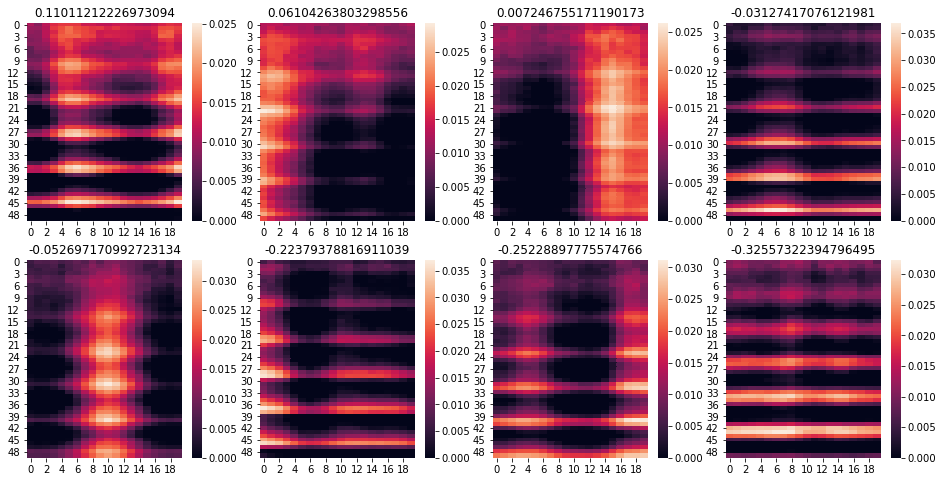

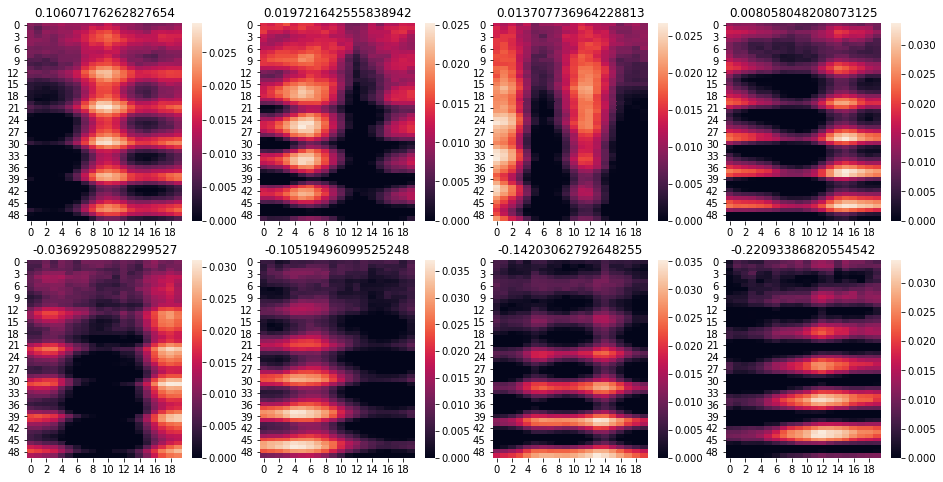

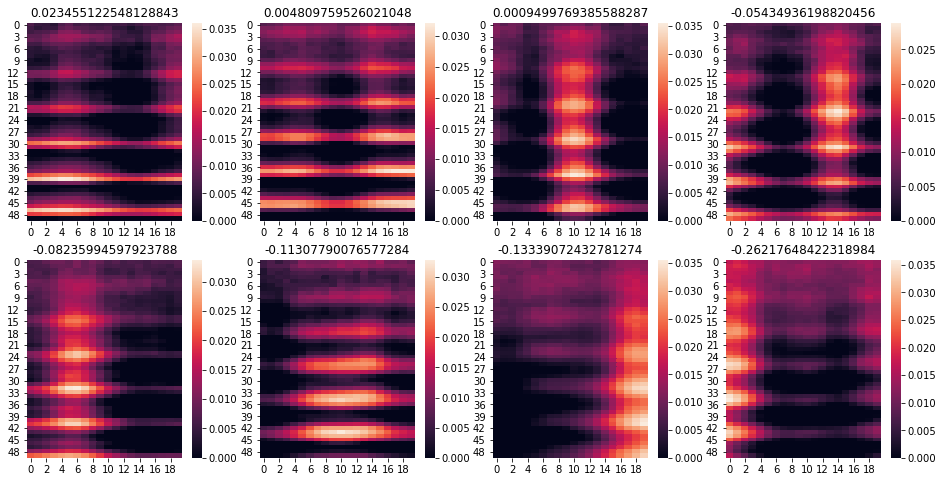

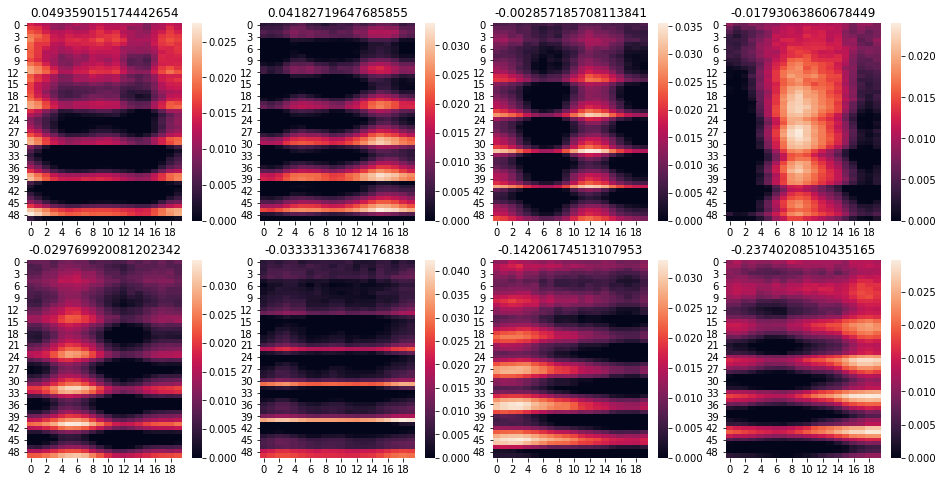

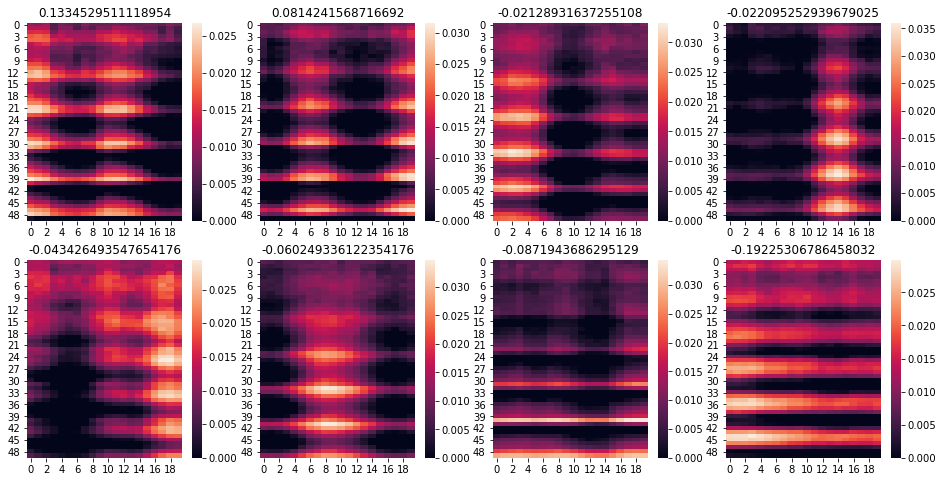

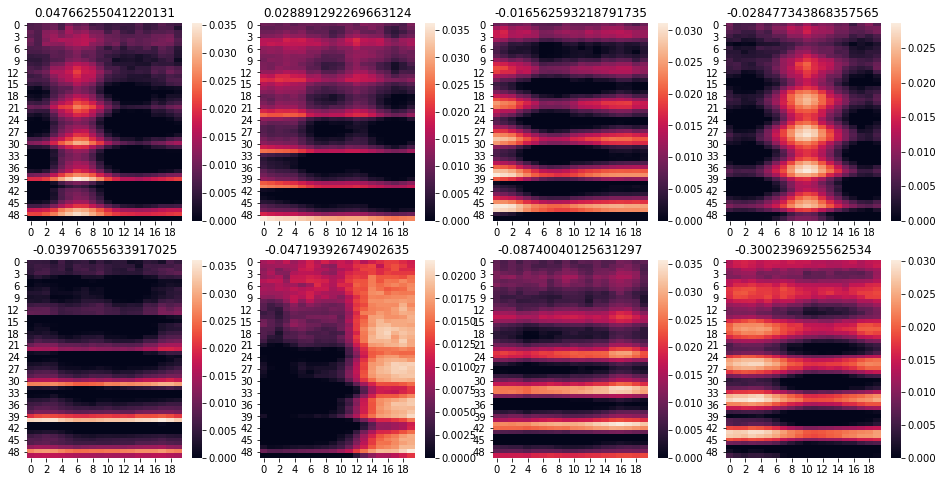

In [241]:
df = pd.concat([df_dynamics_ucla_shifted[df_dynamics_ucla.baseline_width == True], 
          df_dynamics_ucla_shifted[df_dynamics_ucla.y == False]], axis=0).copy()
Y_data = df.y
df = df.drop(['y', 'baseline_width'], axis=1)
dict_ucla1 = sdl_plot(df, Y_data, "1.jpg")

df = df_dynamics_ucla_shifted.copy()
Y_data = df.y
df = df.drop(['y', 'baseline_width'], axis=1)
dict_ucla2 = sdl_plot(df, Y_data, "2.jpg")

df = pd.concat([df_dynamics_ucla_shifted[df_dynamics_ucla.baseline_width == True], 
          df_dynamics_ucla_shifted[df_dynamics_ucla.baseline_width == False][df_dynamics_ucla.y == True]], axis=0).copy()
Y_data = df.baseline_width
df = df.drop(['y', 'baseline_width'], axis=1)
dict_ucla3 = sdl_plot(df, Y_data, "3.jpg")

df = pd.concat([df_dynamics_nws_shifted[df_dynamics_nws.baseline_width == True], 
          df_dynamics_nws_shifted[df_dynamics_nws.y == False]], axis=0).copy()
Y_data = df.y
df = df.drop(['y', 'baseline_width'], axis=1)
dict_nws1 = sdl_plot(df, Y_data, "4.jpg")

df = df_dynamics_nws_shifted.copy()
Y_data = df.y
df = df.drop(['y', 'baseline_width'], axis=1)
dict_nws2 = sdl_plot(df, Y_data, "5.jpg")

df = pd.concat([df_dynamics_nws_shifted[df_dynamics_nws.baseline_width == True],
                df_dynamics_nws_shifted[df_dynamics_nws.baseline_width == False][df_dynamics_nws.y == True]],
               axis=0).copy()
Y_data = df.baseline_width
df = df.drop(['y', 'baseline_width'], axis=1)
dict_nws3 = sdl_plot(df, Y_data, "6.jpg")

In [240]:
dict_arr = [dict_ucla1, dict_ucla2, dict_ucla3, dict_nws1,dict_nws2, dict_nws3]
label = ["ucla sync(conc)+nonsync",
         "ucla sync(conc+nonconc)+nonsync",
         "ucla sync(conc+nonconc)",
         "nws sync(conc)+nonsync",
         "nws sync(conc+nonconc)+nonsync",
         "nws sync(conc+nonconc)",]
for i in range(len(dict_arr)):
    print(label[i], ":", dict_arr[i]["AUC"])

ucla sync(conc)+nonsync : 0.8820666917073577
ucla sync(conc+nonconc)+nonsync : 0.7418680355577814
ucla sync(conc+nonconc) : 0.8329396996428681
nws sync(conc)+nonsync : 0.8308990398603434
nws sync(conc+nonconc)+nonsync : 0.7388461698324951
nws sync(conc+nonconc) : 0.8400800649477898


In [245]:
dict_nws3

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 8,
 'loading': [array([[0.00839911, 0.0086089 , 0.0132669 , ..., 0.00880514, 0.01030616,
          0.00698987],
         [0.00510337, 0.00969879, 0.01539589, ..., 0.00957277, 0.01001624,
          0.00763712],
         [0.00561327, 0.00849099, 0.01596225, ..., 0.00865013, 0.00897273,
          0.00903836],
         ...,
         [0.        , 0.        , 0.        , ..., 0.00988725, 0.0257351 ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.01116657, 0.02647812,
          0.        ],
         [0.        , 0.        , 0.00047357, ..., 0.01245329, 0.02705348,
          0.        ]]),
  array([[13.73380086, -0.02847734, -0.01656259, -0.30023969, -0.0874004 ,
          -0.03970656, -0.04719393,  0.02889129,  0.04766255]])],
 'code': array([[21.67722175, 76.01504537, 86.15382469, ..., 57.70194208,
         76.80832766,  0.        ],
        [95.09134188,

In [202]:
df_temp = df_dynamics_nws.loc[:, 's1_1':'s50_20'].copy()
temp = np.array(df_temp).reshape(-1, 20)
rst = []
kappa = 8
for i in temp:
    differences = [np.max(i) - np.min(i)]
    shifted_opt = i
    for j in range(1,kappa+1):
        shifted = (np.array(i) + j) % kappa
        diff_curr = np.max(shifted) - np.min(shifted)
        if diff_curr<differences:
            differences = diff_curr
            shifted_opt = shifted
    rst.append(shifted_opt)
df_dynamics_nws_shifted = pd.DataFrame(np.array(rst).reshape(-1, 1000))

## SDL

In [9]:
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 8
SDL_BCD_class_new = SDL_BCD(X=[X_train.to_numpy().T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.to_numpy().T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

results_dict_new = SDL_BCD_class_new.fit(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

  2%|▏         | 2/100 [00:00<00:07, 13.03it/s]

initial loading beta [[-0.86066312 -0.07119486 -0.0941708  -0.39786055  0.0240567   0.67358928
  -0.71366174  0.58426165 -0.35405309]]


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


!!! pred_type filter


In [10]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 8,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.01708517e-06, 0.00000000e+00, 0.00000000e+00],
         [6.05384552e-02, 4.28484196e-02, 3.54108427e-02, ...,
          4.12946173e-02, 4.27523529e-02, 2.72292871e-02],
         [0.00000000e+00, 6.10240759e-03, 4.16931694e-03, ...,
          0.00000000e+00, 1.44898425e-03, 2.71796655e-04],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.60673718e-02, 7.77996836e-02, 0.00000000e+00],
         [6.14161331e-02, 4.30363402e-02, 3.53887136e-02, ...,
          4.04245873e-02, 4.28633100e-02, 2.71558993e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 3.30815699e-07]]),
  array([[ 1.25445555,  1.98534655,  0.84900848,  0.96598938,  1.10129449,
          -3.57101767, -1.33061087,  0.8558639 ,  0.5

## NMF

In [21]:
#plotting the dictionary elements(adjacency matrix) as networks and its corresponding degree rank plot
#n: total number of components
#weighted: if true, the degree rank plot is weighted
def plot_DL_adj_deg(n, weighted, filename=None):
    ncol = 8
    nrow = int(np.ceil(n/2))
    fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
    
    if weighted:
        for i in range(n):
            df_adj = pd.DataFrame(W_true.T[i].reshape(20, 20))
            G = nx.Graph()
            G = nx.from_pandas_adjacency(df_adj)
            edges = G.edges()
            weights = [80*G[u][v]['weight'] for u,v in edges]
            
            
            labels = {}
            for node in G.nodes:
                labels[node] = str(node+1)

            nx.draw(G, ax=axs[(i//4)*2,i%4], width=weights,labels = labels, pos = nx.spring_layout(G))
            
            #nx.draw(G, ax=axs[(i//4)*2,i%4], width=weights)
            axs[(i//4)*2,i%4].title.set_text('Synchronizing')
            deg_seq = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
            axs[(i//4)*2+1,i%4].plot(deg_seq, "b-", marker="o")

        for i in range(n):
            df_adj = pd.DataFrame(W_false.T[i].reshape(20, 20))
            G = nx.Graph()
            G = nx.from_pandas_adjacency(df_adj)
            edges = G.edges()
            weights = [80*G[u][v]['weight'] for u,v in edges]
            nx.draw(G, ax=axs[(i//4)*2,i%4+4], width=weights)
            axs[(i//4)*2,i%4+4].title.set_text('Non-Synchronizing')
            deg_seq = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
            axs[(i//4)*2+1,i%4+4].plot(deg_seq, "b-", marker="o")
        if filename != None:
            fig.savefig(filename)
        plt.show()
        
    else:
        for i in range(n):
            df_adj = pd.DataFrame(W_true.T[i].reshape(20, 20))
            G = nx.Graph()
            G = nx.from_pandas_adjacency(df_adj)
            edges = G.edges()
            weights = [80*G[u][v]['weight'] for u,v in edges]
            nx.draw(G, ax=axs[(i//4)*2,i%4], width=weights)
            axs[(i//4)*2,i%4].title.set_text('Synchronizing')
            deg_seq = sorted((d for n, d in G.degree()), reverse=True)
            axs[(i//4)*2+1,i%4].plot(deg_seq, "b-", marker="o")

        for i in range(n):
            df_adj = pd.DataFrame(W_false.T[i].reshape(20, 20))
            G = nx.Graph()
            G = nx.from_pandas_adjacency(df_adj)
            edges = G.edges()
            weights = [80*G[u][v]['weight'] for u,v in edges]
            nx.draw(G, ax=axs[(i//4)*2,i%4+4], width=weights)
            axs[(i//4)*2,i%4+4].title.set_text('Non-Synchronizing')
            deg_seq = sorted((d for n, d in G.degree()), reverse=True)
            axs[(i//4)*2+1,i%4+4].plot(deg_seq, "b-", marker="o")
        if filename != None:
            fig.savefig(filename)
        plt.show()

In [13]:
n = 8
W_false, H = ALS(X=pd.DataFrame(X.T)[df_original.y == 0].to_numpy().T, 
           n_components=n, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

W_true, H = ALS(X=pd.DataFrame(X.T)[df_original.y != 0].to_numpy().T, 
           n_components=n, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  1%|          | 7/1000 [00:00<00:15, 64.60it/s]

iteration 0, reconstruction error 126150.698740
iteration 10, reconstruction error 36457.396425


  3%|▎         | 30/1000 [00:00<00:14, 68.52it/s]

iteration 20, reconstruction error 41009.476442
iteration 30, reconstruction error 40693.982029


  5%|▌         | 54/1000 [00:00<00:13, 70.82it/s]

iteration 40, reconstruction error 37948.249348
iteration 50, reconstruction error 32425.362453


  7%|▋         | 69/1000 [00:01<00:14, 65.97it/s]

iteration 60, reconstruction error 29018.685677
iteration 70, reconstruction error 28385.591433


  9%|▉         | 90/1000 [00:01<00:14, 61.63it/s]

iteration 80, reconstruction error 27970.946064
iteration 90, reconstruction error 27638.302292


 11%|█         | 111/1000 [00:01<00:14, 62.76it/s]

iteration 100, reconstruction error 27372.418622
iteration 110, reconstruction error 27155.234495


 13%|█▎        | 133/1000 [00:02<00:12, 67.43it/s]

iteration 120, reconstruction error 26976.911660
iteration 130, reconstruction error 26824.761666


 15%|█▌        | 150/1000 [00:02<00:11, 75.36it/s]

iteration 140, reconstruction error 26691.710395
iteration 150, reconstruction error 26575.700122


 18%|█▊        | 175/1000 [00:02<00:10, 76.34it/s]

iteration 160, reconstruction error 26474.466401
iteration 170, reconstruction error 26387.512427


 19%|█▉        | 192/1000 [00:02<00:10, 78.03it/s]

iteration 180, reconstruction error 26311.984183
iteration 190, reconstruction error 26244.824680


 21%|██        | 210/1000 [00:02<00:09, 81.85it/s]

iteration 200, reconstruction error 26184.314800
iteration 210, reconstruction error 26129.245975


 24%|██▎       | 237/1000 [00:03<00:09, 82.05it/s]

iteration 220, reconstruction error 26079.479305
iteration 230, reconstruction error 26034.835843


 26%|██▌       | 255/1000 [00:03<00:09, 80.98it/s]

iteration 240, reconstruction error 25995.247591
iteration 250, reconstruction error 25960.619008


 27%|██▋       | 273/1000 [00:03<00:09, 80.26it/s]

iteration 260, reconstruction error 25930.824710
iteration 270, reconstruction error 25905.567967


 29%|██▉       | 291/1000 [00:04<00:08, 79.65it/s]

iteration 280, reconstruction error 25884.376465
iteration 290, reconstruction error 25866.656615


 31%|███       | 309/1000 [00:04<00:08, 80.80it/s]

iteration 300, reconstruction error 25851.778985
iteration 310, reconstruction error 25839.141055


 34%|███▎      | 336/1000 [00:04<00:08, 79.16it/s]

iteration 320, reconstruction error 25828.290265
iteration 330, reconstruction error 25818.869623


 35%|███▌      | 352/1000 [00:04<00:08, 78.92it/s]

iteration 340, reconstruction error 25810.584975
iteration 350, reconstruction error 25803.218659


 37%|███▋      | 370/1000 [00:04<00:07, 81.28it/s]

iteration 360, reconstruction error 25796.599823
iteration 370, reconstruction error 25790.617460


 39%|███▉      | 388/1000 [00:05<00:08, 73.92it/s]

iteration 380, reconstruction error 25785.192025
iteration 390, reconstruction error 25780.247307


 41%|████      | 412/1000 [00:05<00:08, 67.43it/s]

iteration 400, reconstruction error 25775.748586
iteration 410, reconstruction error 25771.686509


 43%|████▎     | 433/1000 [00:05<00:08, 65.34it/s]

iteration 420, reconstruction error 25768.046290
iteration 430, reconstruction error 25764.792276


 45%|████▍     | 449/1000 [00:06<00:07, 71.38it/s]

iteration 440, reconstruction error 25761.868662
iteration 450, reconstruction error 25759.288219


 47%|████▋     | 472/1000 [00:06<00:07, 66.30it/s]

iteration 460, reconstruction error 25757.100320
iteration 470, reconstruction error 25755.182556


 49%|████▉     | 493/1000 [00:06<00:07, 65.62it/s]

iteration 480, reconstruction error 25753.455896
iteration 490, reconstruction error 25751.868053


 52%|█████▏    | 516/1000 [00:07<00:06, 70.59it/s]

iteration 500, reconstruction error 25750.388649
iteration 510, reconstruction error 25748.995893


 53%|█████▎    | 532/1000 [00:07<00:06, 73.49it/s]

iteration 520, reconstruction error 25747.671730
iteration 530, reconstruction error 25746.401256


 56%|█████▌    | 556/1000 [00:07<00:06, 71.20it/s]

iteration 540, reconstruction error 25745.171887
iteration 550, reconstruction error 25743.972094


 57%|█████▋    | 572/1000 [00:07<00:05, 73.02it/s]

iteration 560, reconstruction error 25742.786337
iteration 570, reconstruction error 25741.603881


 59%|█████▉    | 589/1000 [00:08<00:05, 76.02it/s]

iteration 580, reconstruction error 25740.414201
iteration 590, reconstruction error 25739.206803


 61%|██████    | 606/1000 [00:08<00:05, 73.73it/s]

iteration 600, reconstruction error 25737.971003
iteration 610, reconstruction error 25736.697355


 63%|██████▎   | 628/1000 [00:08<00:05, 66.71it/s]

iteration 620, reconstruction error 25735.381215
iteration 630, reconstruction error 25734.009670


 65%|██████▌   | 651/1000 [00:09<00:04, 71.35it/s]

iteration 640, reconstruction error 25732.571483
iteration 650, reconstruction error 25731.055143


 67%|██████▋   | 673/1000 [00:09<00:05, 63.04it/s]

iteration 660, reconstruction error 25729.451286
iteration 670, reconstruction error 25727.749055


 69%|██████▉   | 690/1000 [00:09<00:04, 72.82it/s]

iteration 680, reconstruction error 25725.941840
iteration 690, reconstruction error 25724.031529


 71%|███████▏  | 713/1000 [00:10<00:04, 63.34it/s]

iteration 700, reconstruction error 25722.022439
iteration 710, reconstruction error 25719.911145


 73%|███████▎  | 727/1000 [00:10<00:04, 61.43it/s]

iteration 720, reconstruction error 25717.697490
iteration 730, reconstruction error 25715.394533


 75%|███████▌  | 750/1000 [00:10<00:03, 68.73it/s]

iteration 740, reconstruction error 25713.043675
iteration 750, reconstruction error 25710.670234


 77%|███████▋  | 774/1000 [00:10<00:03, 72.20it/s]

iteration 760, reconstruction error 25708.359073
iteration 770, reconstruction error 25706.175857


 79%|███████▉  | 790/1000 [00:11<00:02, 72.52it/s]

iteration 780, reconstruction error 25704.245139
iteration 790, reconstruction error 25702.550914


 81%|████████▏ | 814/1000 [00:11<00:02, 74.60it/s]

iteration 800, reconstruction error 25700.988577
iteration 810, reconstruction error 25699.520610


 83%|████████▎ | 831/1000 [00:11<00:02, 76.26it/s]

iteration 820, reconstruction error 25698.127380
iteration 830, reconstruction error 25696.798267


 85%|████████▍ | 849/1000 [00:11<00:01, 78.72it/s]

iteration 840, reconstruction error 25695.525853
iteration 850, reconstruction error 25694.305268


 88%|████████▊ | 875/1000 [00:12<00:01, 80.11it/s]

iteration 860, reconstruction error 25693.132926
iteration 870, reconstruction error 25692.006074


 89%|████████▉ | 892/1000 [00:12<00:01, 77.94it/s]

iteration 880, reconstruction error 25690.923041
iteration 890, reconstruction error 25689.883911


 91%|█████████ | 909/1000 [00:12<00:01, 73.88it/s]

iteration 900, reconstruction error 25688.888637
iteration 910, reconstruction error 25687.935197


 93%|█████████▎| 933/1000 [00:12<00:00, 73.78it/s]

iteration 920, reconstruction error 25687.021957
iteration 930, reconstruction error 25686.147726


 95%|█████████▍| 949/1000 [00:13<00:00, 73.75it/s]

iteration 940, reconstruction error 25685.311326
iteration 950, reconstruction error 25684.512639


 97%|█████████▋| 974/1000 [00:13<00:00, 77.23it/s]

iteration 960, reconstruction error 25683.751378
iteration 970, reconstruction error 25683.026281


 99%|█████████▉| 990/1000 [00:13<00:00, 74.43it/s]

iteration 980, reconstruction error 25682.336266
iteration 990, reconstruction error 25681.680402


  1%|          | 7/1000 [00:00<00:33, 29.77it/s]

iteration 0, reconstruction error 389130.887799


  2%|▏         | 15/1000 [00:00<00:32, 30.02it/s]

iteration 10, reconstruction error 109965.056016


  3%|▎         | 26/1000 [00:00<00:33, 29.38it/s]

iteration 20, reconstruction error 120345.926482


  4%|▎         | 37/1000 [00:01<00:32, 29.25it/s]

iteration 30, reconstruction error 112576.724475


  4%|▍         | 45/1000 [00:01<00:32, 29.25it/s]

iteration 40, reconstruction error 97682.654068


  5%|▌         | 54/1000 [00:01<00:35, 26.33it/s]

iteration 50, reconstruction error 87536.539351


  7%|▋         | 66/1000 [00:02<00:34, 26.73it/s]

iteration 60, reconstruction error 84587.748665


  8%|▊         | 75/1000 [00:02<00:34, 26.93it/s]

iteration 70, reconstruction error 82542.921282


  8%|▊         | 85/1000 [00:03<00:32, 28.01it/s]

iteration 80, reconstruction error 80729.931683


 10%|▉         | 95/1000 [00:03<00:34, 26.35it/s]

iteration 90, reconstruction error 79472.568913


 10%|█         | 104/1000 [00:03<00:36, 24.50it/s]

iteration 100, reconstruction error 78618.424206


 12%|█▏        | 116/1000 [00:04<00:37, 23.67it/s]

iteration 110, reconstruction error 78001.710487


 12%|█▎        | 125/1000 [00:04<00:36, 23.79it/s]

iteration 120, reconstruction error 77533.216871


 14%|█▎        | 135/1000 [00:05<00:31, 27.57it/s]

iteration 130, reconstruction error 77162.188177


 15%|█▍        | 146/1000 [00:05<00:29, 29.32it/s]

iteration 140, reconstruction error 76861.415447


 15%|█▌        | 154/1000 [00:05<00:31, 27.05it/s]

iteration 150, reconstruction error 76615.105071


 17%|█▋        | 166/1000 [00:06<00:33, 25.27it/s]

iteration 160, reconstruction error 76411.291683


 18%|█▊        | 175/1000 [00:06<00:34, 24.02it/s]

iteration 170, reconstruction error 76240.814137


 18%|█▊        | 184/1000 [00:07<00:34, 23.43it/s]

iteration 180, reconstruction error 76096.613508


 20%|█▉        | 197/1000 [00:07<00:31, 25.69it/s]

iteration 190, reconstruction error 75973.066405


 20%|██        | 204/1000 [00:07<00:29, 26.59it/s]

iteration 200, reconstruction error 75867.667606


 22%|██▏       | 215/1000 [00:08<00:27, 28.36it/s]

iteration 210, reconstruction error 75774.236266


 22%|██▎       | 225/1000 [00:08<00:28, 26.85it/s]

iteration 220, reconstruction error 75689.193086


 23%|██▎       | 234/1000 [00:08<00:32, 23.89it/s]

iteration 230, reconstruction error 75610.746146


 24%|██▍       | 244/1000 [00:09<00:28, 26.53it/s]

iteration 240, reconstruction error 75538.687149


 25%|██▌       | 254/1000 [00:09<00:28, 26.35it/s]

iteration 250, reconstruction error 75472.376165


 27%|██▋       | 266/1000 [00:10<00:29, 24.52it/s]

iteration 260, reconstruction error 75411.052127


 28%|██▊       | 275/1000 [00:10<00:30, 23.86it/s]

iteration 270, reconstruction error 75354.512335


 28%|██▊       | 284/1000 [00:10<00:29, 24.16it/s]

iteration 280, reconstruction error 75302.298630


 30%|██▉       | 296/1000 [00:11<00:27, 25.56it/s]

iteration 290, reconstruction error 75254.014345


 31%|███       | 306/1000 [00:11<00:25, 26.99it/s]

iteration 300, reconstruction error 75209.634981


 32%|███▏      | 315/1000 [00:12<00:25, 27.30it/s]

iteration 310, reconstruction error 75169.235932


 32%|███▏      | 324/1000 [00:12<00:26, 25.66it/s]

iteration 320, reconstruction error 75132.633234


 34%|███▎      | 336/1000 [00:12<00:26, 25.42it/s]

iteration 330, reconstruction error 75099.325897


 34%|███▍      | 345/1000 [00:13<00:24, 26.55it/s]

iteration 340, reconstruction error 75068.837357


 35%|███▌      | 354/1000 [00:13<00:24, 26.74it/s]

iteration 350, reconstruction error 75040.802984


 36%|███▋      | 364/1000 [00:13<00:23, 27.21it/s]

iteration 360, reconstruction error 75014.760963


 37%|███▋      | 374/1000 [00:14<00:22, 27.59it/s]

iteration 370, reconstruction error 74990.417741


 39%|███▊      | 387/1000 [00:14<00:21, 28.79it/s]

iteration 380, reconstruction error 74967.659932


 40%|███▉      | 395/1000 [00:15<00:20, 29.04it/s]

iteration 390, reconstruction error 74946.394331


 41%|████      | 406/1000 [00:15<00:20, 29.70it/s]

iteration 400, reconstruction error 74926.547631


 41%|████▏     | 414/1000 [00:15<00:20, 29.12it/s]

iteration 410, reconstruction error 74908.153163


 43%|████▎     | 426/1000 [00:16<00:19, 29.78it/s]

iteration 420, reconstruction error 74891.279461


 43%|████▎     | 434/1000 [00:16<00:19, 29.29it/s]

iteration 430, reconstruction error 74875.937384


 45%|████▍     | 446/1000 [00:16<00:18, 29.78it/s]

iteration 440, reconstruction error 74862.095819


 45%|████▌     | 454/1000 [00:17<00:19, 28.72it/s]

iteration 450, reconstruction error 74849.788895


 46%|████▋     | 465/1000 [00:17<00:18, 29.00it/s]

iteration 460, reconstruction error 74839.090183


 48%|████▊     | 476/1000 [00:17<00:17, 29.81it/s]

iteration 470, reconstruction error 74829.934191


 48%|████▊     | 484/1000 [00:18<00:17, 29.20it/s]

iteration 480, reconstruction error 74822.116460


 50%|████▉     | 496/1000 [00:18<00:16, 29.87it/s]

iteration 490, reconstruction error 74815.439364


 50%|█████     | 504/1000 [00:18<00:17, 28.73it/s]

iteration 500, reconstruction error 74809.744210


 52%|█████▏    | 516/1000 [00:19<00:16, 29.62it/s]

iteration 510, reconstruction error 74804.872341


 52%|█████▏    | 524/1000 [00:19<00:16, 28.71it/s]

iteration 520, reconstruction error 74800.683509


 53%|█████▎    | 534/1000 [00:19<00:17, 26.67it/s]

iteration 530, reconstruction error 74797.064860


 55%|█████▍    | 545/1000 [00:20<00:16, 28.18it/s]

iteration 540, reconstruction error 74793.915584


 56%|█████▌    | 556/1000 [00:20<00:15, 29.13it/s]

iteration 550, reconstruction error 74791.148598


 57%|█████▋    | 566/1000 [00:20<00:14, 29.29it/s]

iteration 560, reconstruction error 74788.701570


 58%|█████▊    | 577/1000 [00:21<00:14, 29.55it/s]

iteration 570, reconstruction error 74786.512253


 59%|█████▊    | 587/1000 [00:21<00:14, 29.24it/s]

iteration 580, reconstruction error 74784.523756


 59%|█████▉    | 594/1000 [00:21<00:14, 28.41it/s]

iteration 590, reconstruction error 74782.697117


 60%|██████    | 605/1000 [00:22<00:13, 29.28it/s]

iteration 600, reconstruction error 74780.996598


 62%|██████▏   | 616/1000 [00:22<00:13, 28.97it/s]

iteration 610, reconstruction error 74779.400760


 63%|██████▎   | 626/1000 [00:23<00:12, 28.99it/s]

iteration 620, reconstruction error 74777.891087


 64%|██████▎   | 637/1000 [00:23<00:12, 29.45it/s]

iteration 630, reconstruction error 74776.455522


 64%|██████▍   | 645/1000 [00:23<00:11, 29.69it/s]

iteration 640, reconstruction error 74775.085229


 66%|██████▌   | 657/1000 [00:24<00:11, 30.29it/s]

iteration 650, reconstruction error 74773.773336


 66%|██████▋   | 665/1000 [00:24<00:11, 29.65it/s]

iteration 660, reconstruction error 74772.515368


 68%|██████▊   | 677/1000 [00:24<00:10, 30.17it/s]

iteration 670, reconstruction error 74771.307997


 68%|██████▊   | 685/1000 [00:25<00:10, 29.69it/s]

iteration 680, reconstruction error 74770.148721


 70%|██████▉   | 697/1000 [00:25<00:10, 29.75it/s]

iteration 690, reconstruction error 74769.036376


 70%|███████   | 705/1000 [00:25<00:09, 29.57it/s]

iteration 700, reconstruction error 74767.970933


 72%|███████▏  | 717/1000 [00:26<00:09, 30.33it/s]

iteration 710, reconstruction error 74766.954528


 72%|███████▎  | 725/1000 [00:26<00:09, 29.62it/s]

iteration 720, reconstruction error 74765.985594


 74%|███████▎  | 735/1000 [00:26<00:09, 29.00it/s]

iteration 730, reconstruction error 74765.063101


 75%|███████▍  | 746/1000 [00:27<00:08, 29.65it/s]

iteration 740, reconstruction error 74764.185456


 76%|███████▌  | 757/1000 [00:27<00:08, 29.31it/s]

iteration 750, reconstruction error 74763.351257


 77%|███████▋  | 767/1000 [00:27<00:07, 29.22it/s]

iteration 760, reconstruction error 74762.559348


 78%|███████▊  | 777/1000 [00:28<00:07, 28.78it/s]

iteration 770, reconstruction error 74761.808382


 79%|███████▊  | 787/1000 [00:28<00:07, 29.62it/s]

iteration 780, reconstruction error 74761.097036


 80%|███████▉  | 795/1000 [00:28<00:07, 29.16it/s]

iteration 790, reconstruction error 74760.424262


 80%|████████  | 805/1000 [00:29<00:06, 29.11it/s]

iteration 800, reconstruction error 74759.789066


 82%|████████▏ | 815/1000 [00:29<00:06, 28.69it/s]

iteration 810, reconstruction error 74759.189743


 83%|████████▎ | 826/1000 [00:29<00:05, 29.07it/s]

iteration 820, reconstruction error 74758.625051


 84%|████████▎ | 836/1000 [00:30<00:05, 29.19it/s]

iteration 830, reconstruction error 74758.093830


 85%|████████▍ | 846/1000 [00:30<00:05, 29.62it/s]

iteration 840, reconstruction error 74757.594855


 86%|████████▌ | 857/1000 [00:30<00:04, 29.53it/s]

iteration 850, reconstruction error 74757.126933


 87%|████████▋ | 867/1000 [00:31<00:04, 29.47it/s]

iteration 860, reconstruction error 74756.688320


 88%|████████▊ | 877/1000 [00:31<00:04, 29.29it/s]

iteration 870, reconstruction error 74756.277437


 88%|████████▊ | 885/1000 [00:31<00:03, 29.10it/s]

iteration 880, reconstruction error 74755.892861


 90%|████████▉ | 897/1000 [00:32<00:03, 29.88it/s]

iteration 890, reconstruction error 74755.532896


 90%|█████████ | 905/1000 [00:32<00:03, 29.60it/s]

iteration 900, reconstruction error 74755.196447


 92%|█████████▏| 916/1000 [00:32<00:02, 29.58it/s]

iteration 910, reconstruction error 74754.881991


 92%|█████████▏| 924/1000 [00:33<00:02, 29.02it/s]

iteration 920, reconstruction error 74754.587759


 94%|█████████▎| 936/1000 [00:33<00:02, 29.49it/s]

iteration 930, reconstruction error 74754.312094


 95%|█████████▍| 946/1000 [00:34<00:01, 29.87it/s]

iteration 940, reconstruction error 74754.053569


 95%|█████████▌| 954/1000 [00:34<00:01, 28.90it/s]

iteration 950, reconstruction error 74753.810822


 97%|█████████▋| 966/1000 [00:34<00:01, 29.55it/s]

iteration 960, reconstruction error 74753.582687


 97%|█████████▋| 974/1000 [00:34<00:00, 29.11it/s]

iteration 970, reconstruction error 74753.367763


 99%|█████████▊| 986/1000 [00:35<00:00, 30.37it/s]

iteration 980, reconstruction error 74753.164710


 99%|█████████▉| 994/1000 [00:35<00:00, 29.71it/s]

iteration 990, reconstruction error 74752.972412


100%|██████████| 1000/1000 [00:35<00:00, 27.92it/s]


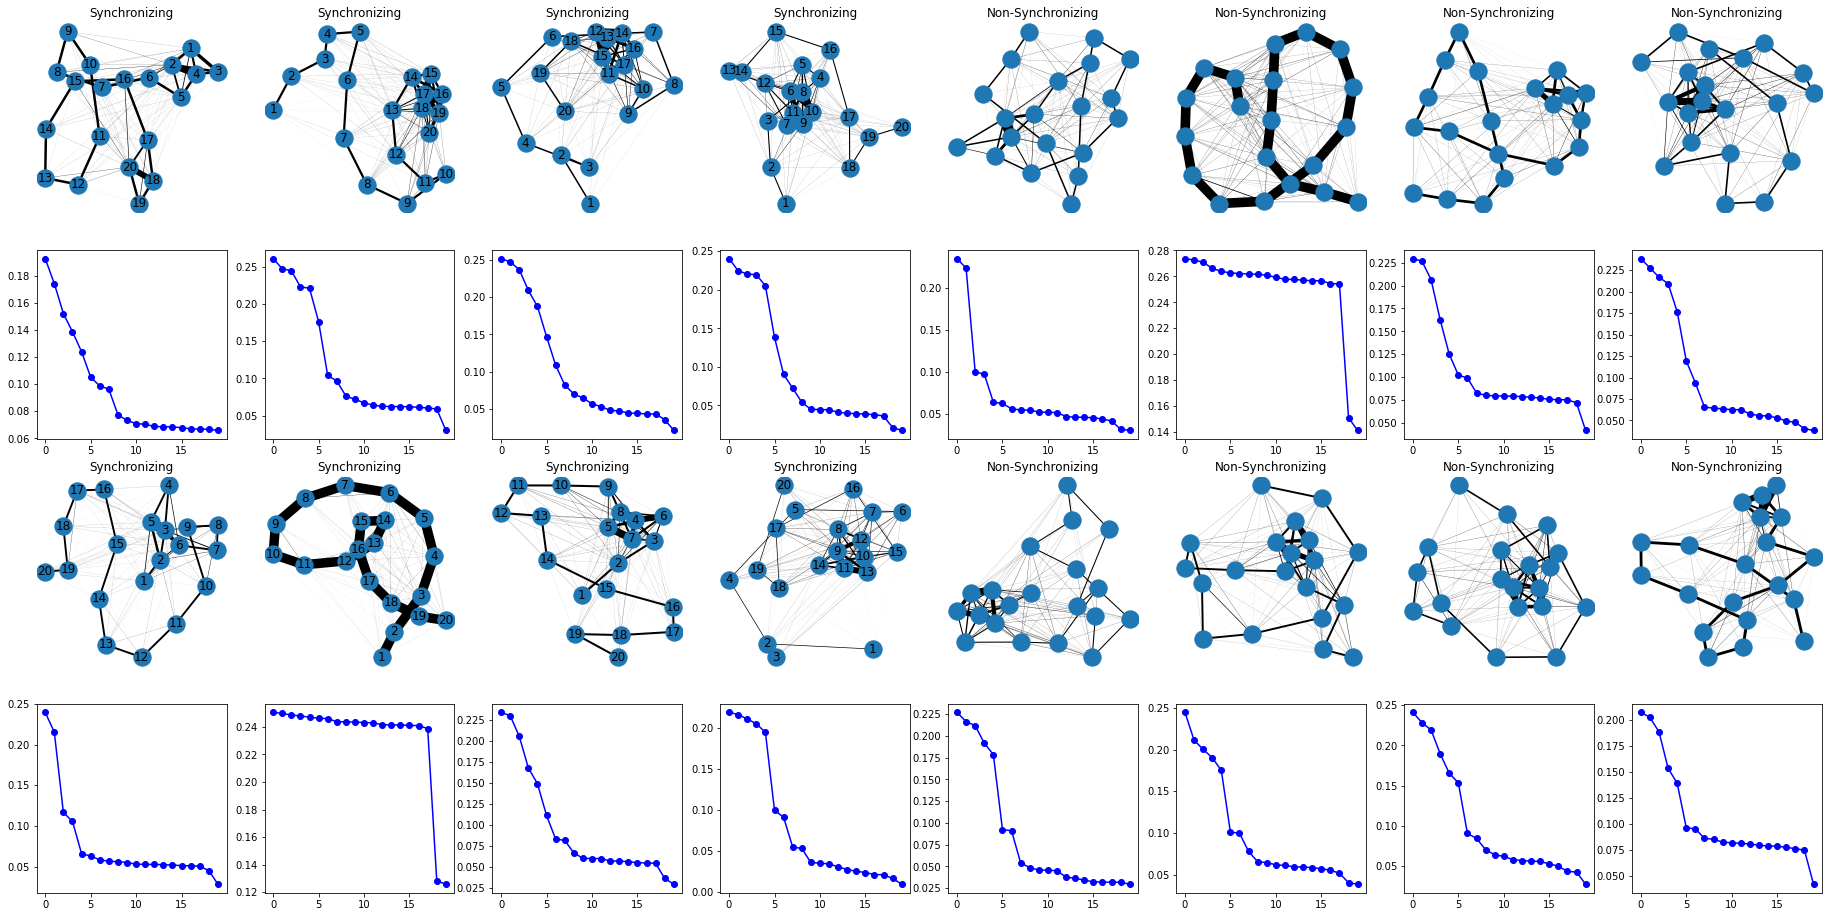

In [22]:
plot_DL_adj_deg(n, True)
#add regression coef, heatmap of dynamics
#use basic graph features first

## Node2vec

In [24]:
n2v = pd.read_csv("./my_data/UCLA26_20walk_8kappa_graph2vec.csv", header = None)
n2v

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.051089,0.059887,0.051052,-0.049013,-0.054264,-0.028956,-0.027387,0.029444,-0.042619,-0.054072,-0.029567,0.062103,-0.029794,0.009589,0.056234,0.027708
1,0.050570,0.059278,0.050534,-0.048515,-0.053713,-0.028662,-0.027108,0.029145,-0.042186,-0.053523,-0.029266,0.061472,-0.029492,0.009491,0.055663,0.027426
2,0.050897,0.059663,0.050861,-0.048829,-0.054061,-0.028848,-0.027284,0.029334,-0.042460,-0.053870,-0.029456,0.061871,-0.029683,0.009553,0.056024,0.027604
3,0.051148,0.059956,0.051111,-0.049069,-0.054326,-0.028989,-0.027418,0.029478,-0.042668,-0.054134,-0.029601,0.062175,-0.029829,0.009600,0.056299,0.027740
4,0.050802,0.059551,0.050766,-0.048738,-0.053959,-0.028793,-0.027233,0.029279,-0.042380,-0.053769,-0.029401,0.061754,-0.029627,0.009535,0.055918,0.027552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.050911,0.059679,0.050875,-0.048842,-0.054075,-0.028855,-0.027291,0.029342,-0.042471,-0.053884,-0.029464,0.061887,-0.029691,0.009555,0.056039,0.027611
9996,0.050517,0.059216,0.050481,-0.048464,-0.053656,-0.028632,-0.027080,0.029115,-0.042142,-0.053467,-0.029235,0.061408,-0.029461,0.009481,0.055604,0.027397
9997,0.050709,0.059442,0.050673,-0.048649,-0.053861,-0.028741,-0.027183,0.029226,-0.042303,-0.053670,-0.029347,0.061641,-0.029573,0.009517,0.055816,0.027502
9998,0.050860,0.059619,0.050824,-0.048794,-0.054021,-0.028827,-0.027264,0.029313,-0.042429,-0.053831,-0.029434,0.061826,-0.029661,0.009546,0.055983,0.027584


In [25]:
df_original.y

0        True
1        True
2       False
3        True
4        True
        ...  
9995    False
9996     True
9997     True
9998     True
9999    False
Name: y, Length: 10000, dtype: bool

In [26]:
Y_data = df_original.y
df = pd.DataFrame(n2v)

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)

In [27]:
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 8
SDL_BCD_class_new = SDL_BCD(X=[X_train.to_numpy().T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.to_numpy().T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

results_dict_new = SDL_BCD_class_new.fit(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

  5%|▌         | 5/100 [00:00<00:02, 43.29it/s]

initial loading beta [[ 0.22029899 -0.57174017 -0.89266465  0.03311836 -0.27333054  0.21415705
   0.94460035 -0.29723557 -0.24033813]]


100%|██████████| 100/100 [00:01<00:00, 77.81it/s]


!!! pred_type filter


In [28]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 8,
 'loading': [array([[5.09944378e-03, 1.84754136e-01, 3.87378939e-02, 2.98284506e-02,
          1.87747915e-01, 1.00741043e-01, 1.75391347e-02, 1.09070790e-01],
         [6.52515013e-02, 2.29155609e-01, 3.85068949e-02, 1.34916030e-02,
          7.22782173e-03, 2.48229109e-02, 2.05743782e-01, 7.50149365e-02],
         [4.35879122e-03, 2.86974491e-01, 3.49674015e-02, 1.81653023e-02,
          1.50200303e-01, 5.00804862e-02, 1.17954191e-01, 8.03412888e-02],
         [0.00000000e+00, 1.99848651e-01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.68365180e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          9.49882459e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.72043931e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00,

In [19]:
n = 8
W_false, H = ALS(X=pd.DataFrame(n2v)[df_original.y == 0].to_numpy().T, 
           n_components=n, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

W_true, H = ALS(X=pd.DataFrame(n2v)[df_original.y != 0].to_numpy().T, 
           n_components=n, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  2%|▏         | 20/1000 [00:00<00:09, 98.92it/s]

iteration 0, reconstruction error 6322.736313
iteration 10, reconstruction error 5382.904519
iteration 20, reconstruction error 5192.553806


  4%|▍         | 44/1000 [00:00<00:08, 109.79it/s]

iteration 30, reconstruction error 5151.130880
iteration 40, reconstruction error 5123.483007
iteration 50, reconstruction error 5100.963971


  8%|▊         | 81/1000 [00:00<00:07, 117.95it/s]

iteration 60, reconstruction error 5085.461338
iteration 70, reconstruction error 5072.026710
iteration 80, reconstruction error 5061.563478


 11%|█         | 107/1000 [00:00<00:07, 121.86it/s]

iteration 90, reconstruction error 5054.165493
iteration 100, reconstruction error 5050.789829
iteration 110, reconstruction error 5048.599886


 15%|█▍        | 147/1000 [00:01<00:06, 125.20it/s]

iteration 120, reconstruction error 5046.902879
iteration 130, reconstruction error 5045.522207
iteration 140, reconstruction error 5044.333737


 17%|█▋        | 173/1000 [00:01<00:06, 125.68it/s]

iteration 150, reconstruction error 5043.329450
iteration 160, reconstruction error 5042.731090
iteration 170, reconstruction error 5042.458993


 20%|█▉        | 199/1000 [00:01<00:06, 124.90it/s]

iteration 180, reconstruction error 5042.291608
iteration 190, reconstruction error 5042.168216
iteration 200, reconstruction error 5042.066928


 22%|██▎       | 225/1000 [00:01<00:06, 121.47it/s]

iteration 210, reconstruction error 5041.977225
iteration 220, reconstruction error 5041.894764
iteration 230, reconstruction error 5041.819147


 26%|██▋       | 264/1000 [00:02<00:06, 122.53it/s]

iteration 240, reconstruction error 5041.748816
iteration 250, reconstruction error 5041.682990
iteration 260, reconstruction error 5041.621472


 29%|██▉       | 290/1000 [00:02<00:05, 125.05it/s]

iteration 270, reconstruction error 5041.564113
iteration 280, reconstruction error 5041.511431
iteration 290, reconstruction error 5041.463403


 32%|███▏      | 315/1000 [00:02<00:05, 115.40it/s]

iteration 300, reconstruction error 5041.419923
iteration 310, reconstruction error 5041.380428
iteration 320, reconstruction error 5041.344492


 35%|███▌      | 353/1000 [00:02<00:05, 113.50it/s]

iteration 330, reconstruction error 5041.311769
iteration 340, reconstruction error 5041.282054
iteration 350, reconstruction error 5041.255201


 38%|███▊      | 378/1000 [00:03<00:05, 112.24it/s]

iteration 360, reconstruction error 5041.231040
iteration 370, reconstruction error 5041.209411
iteration 380, reconstruction error 5041.190196


 42%|████▏     | 415/1000 [00:03<00:04, 118.88it/s]

iteration 390, reconstruction error 5041.173166
iteration 400, reconstruction error 5041.158113
iteration 410, reconstruction error 5041.144883


 44%|████▍     | 440/1000 [00:03<00:04, 119.61it/s]

iteration 420, reconstruction error 5041.133291
iteration 430, reconstruction error 5041.123189
iteration 440, reconstruction error 5041.114431


 46%|████▋     | 465/1000 [00:03<00:04, 120.27it/s]

iteration 450, reconstruction error 5041.106870
iteration 460, reconstruction error 5041.100487
iteration 470, reconstruction error 5041.095173


 50%|█████     | 504/1000 [00:04<00:04, 123.16it/s]

iteration 480, reconstruction error 5041.090737
iteration 490, reconstruction error 5041.087029
iteration 500, reconstruction error 5041.083929


 53%|█████▎    | 530/1000 [00:04<00:03, 123.37it/s]

iteration 510, reconstruction error 5041.081397
iteration 520, reconstruction error 5041.079378
iteration 530, reconstruction error 5041.077775


 56%|█████▌    | 556/1000 [00:04<00:03, 120.92it/s]

iteration 540, reconstruction error 5041.076533
iteration 550, reconstruction error 5041.075577
iteration 560, reconstruction error 5041.074844


 60%|█████▉    | 596/1000 [00:04<00:03, 124.79it/s]

iteration 570, reconstruction error 5041.074286
iteration 580, reconstruction error 5041.073858
iteration 590, reconstruction error 5041.073528


 62%|██████▏   | 622/1000 [00:05<00:03, 124.53it/s]

iteration 600, reconstruction error 5041.073270
iteration 610, reconstruction error 5041.073068
iteration 620, reconstruction error 5041.072909


 65%|██████▍   | 649/1000 [00:05<00:02, 127.01it/s]

iteration 630, reconstruction error 5041.072784
iteration 640, reconstruction error 5041.072684
iteration 650, reconstruction error 5041.072605


 68%|██████▊   | 676/1000 [00:05<00:02, 127.94it/s]

iteration 660, reconstruction error 5041.072542
iteration 670, reconstruction error 5041.072492
iteration 680, reconstruction error 5041.072452


 72%|███████▏  | 716/1000 [00:05<00:02, 126.04it/s]

iteration 690, reconstruction error 5041.072420
iteration 700, reconstruction error 5041.072394
iteration 710, reconstruction error 5041.072374


 74%|███████▍  | 743/1000 [00:06<00:02, 125.69it/s]

iteration 720, reconstruction error 5041.072357
iteration 730, reconstruction error 5041.072344
iteration 740, reconstruction error 5041.072334


 77%|███████▋  | 770/1000 [00:06<00:01, 126.10it/s]

iteration 750, reconstruction error 5041.072325
iteration 760, reconstruction error 5041.072319
iteration 770, reconstruction error 5041.072313


 80%|███████▉  | 796/1000 [00:06<00:01, 123.18it/s]

iteration 780, reconstruction error 5041.072309
iteration 790, reconstruction error 5041.072306
iteration 800, reconstruction error 5041.072303


 84%|████████▎ | 836/1000 [00:06<00:01, 125.62it/s]

iteration 810, reconstruction error 5041.072301
iteration 820, reconstruction error 5041.072299
iteration 830, reconstruction error 5041.072297


 86%|████████▌ | 862/1000 [00:07<00:01, 124.97it/s]

iteration 840, reconstruction error 5041.072296
iteration 850, reconstruction error 5041.072295
iteration 860, reconstruction error 5041.072295


 89%|████████▉ | 888/1000 [00:07<00:00, 125.01it/s]

iteration 870, reconstruction error 5041.072294
iteration 880, reconstruction error 5041.072293
iteration 890, reconstruction error 5041.072293


 92%|█████████▏| 915/1000 [00:07<00:00, 126.74it/s]

iteration 900, reconstruction error 5041.072293
iteration 910, reconstruction error 5041.072293
iteration 920, reconstruction error 5041.072292


 96%|█████████▌| 955/1000 [00:07<00:00, 124.72it/s]

iteration 930, reconstruction error 5041.072292
iteration 940, reconstruction error 5041.072292
iteration 950, reconstruction error 5041.072292


 98%|█████████▊| 981/1000 [00:08<00:00, 123.75it/s]

iteration 960, reconstruction error 5041.072292
iteration 970, reconstruction error 5041.072292
iteration 980, reconstruction error 5041.072292


  0%|          | 3/1000 [00:00<00:39, 25.26it/s]

iteration 990, reconstruction error 5041.072292
iteration 0, reconstruction error 18976.737874


  2%|▏         | 15/1000 [00:00<00:30, 32.69it/s]

iteration 10, reconstruction error 16358.339534


  3%|▎         | 27/1000 [00:00<00:29, 32.89it/s]

iteration 20, reconstruction error 15756.003076


  4%|▎         | 35/1000 [00:01<00:29, 32.72it/s]

iteration 30, reconstruction error 15497.786343


  5%|▍         | 47/1000 [00:01<00:27, 34.07it/s]

iteration 40, reconstruction error 15387.107455


  6%|▌         | 55/1000 [00:01<00:27, 33.90it/s]

iteration 50, reconstruction error 15346.458356


  7%|▋         | 67/1000 [00:02<00:27, 33.73it/s]

iteration 60, reconstruction error 15325.806877


  8%|▊         | 75/1000 [00:02<00:27, 33.57it/s]

iteration 70, reconstruction error 15314.485457


  9%|▊         | 87/1000 [00:02<00:27, 33.74it/s]

iteration 80, reconstruction error 15306.497254


 10%|▉         | 95/1000 [00:02<00:25, 35.00it/s]

iteration 90, reconstruction error 15299.477722


 11%|█         | 107/1000 [00:03<00:24, 35.93it/s]

iteration 100, reconstruction error 15294.382778


 12%|█▏        | 115/1000 [00:03<00:24, 36.37it/s]

iteration 110, reconstruction error 15291.759812


 13%|█▎        | 127/1000 [00:03<00:24, 35.76it/s]

iteration 120, reconstruction error 15289.911772


 14%|█▎        | 135/1000 [00:03<00:24, 34.75it/s]

iteration 130, reconstruction error 15288.196451


 15%|█▍        | 147/1000 [00:04<00:24, 34.43it/s]

iteration 140, reconstruction error 15286.279814


 16%|█▌        | 155/1000 [00:04<00:25, 33.44it/s]

iteration 150, reconstruction error 15283.876373


 17%|█▋        | 167/1000 [00:04<00:24, 34.15it/s]

iteration 160, reconstruction error 15280.645171


 18%|█▊        | 175/1000 [00:05<00:24, 33.00it/s]

iteration 170, reconstruction error 15276.152098


 19%|█▊        | 187/1000 [00:05<00:24, 33.85it/s]

iteration 180, reconstruction error 15269.668459


 20%|█▉        | 195/1000 [00:05<00:23, 33.97it/s]

iteration 190, reconstruction error 15259.843737


 21%|██        | 207/1000 [00:06<00:23, 33.18it/s]

iteration 200, reconstruction error 15243.772539


 22%|██▏       | 215/1000 [00:06<00:23, 33.48it/s]

iteration 210, reconstruction error 15221.985518


 23%|██▎       | 227/1000 [00:06<00:22, 34.09it/s]

iteration 220, reconstruction error 15201.942137


 24%|██▎       | 235/1000 [00:06<00:22, 33.81it/s]

iteration 230, reconstruction error 15180.594491


 25%|██▍       | 247/1000 [00:07<00:21, 34.38it/s]

iteration 240, reconstruction error 15165.197401


 26%|██▌       | 255/1000 [00:07<00:22, 33.27it/s]

iteration 250, reconstruction error 15156.225832


 27%|██▋       | 267/1000 [00:07<00:22, 32.87it/s]

iteration 260, reconstruction error 15148.286324


 28%|██▊       | 275/1000 [00:08<00:21, 33.00it/s]

iteration 270, reconstruction error 15138.419568


 29%|██▊       | 287/1000 [00:08<00:21, 33.45it/s]

iteration 280, reconstruction error 15125.547407


 30%|██▉       | 295/1000 [00:08<00:21, 33.44it/s]

iteration 290, reconstruction error 15113.645753


 31%|███       | 307/1000 [00:09<00:20, 33.33it/s]

iteration 300, reconstruction error 15109.491915


 32%|███▏      | 315/1000 [00:09<00:20, 33.29it/s]

iteration 310, reconstruction error 15107.888969


 33%|███▎      | 327/1000 [00:09<00:19, 34.33it/s]

iteration 320, reconstruction error 15107.230424


 34%|███▎      | 335/1000 [00:09<00:19, 33.84it/s]

iteration 330, reconstruction error 15106.949291


 35%|███▍      | 347/1000 [00:10<00:19, 33.71it/s]

iteration 340, reconstruction error 15106.823756


 36%|███▌      | 355/1000 [00:10<00:19, 33.00it/s]

iteration 350, reconstruction error 15106.763465


 37%|███▋      | 367/1000 [00:10<00:18, 33.71it/s]

iteration 360, reconstruction error 15106.731855


 38%|███▊      | 375/1000 [00:11<00:18, 33.10it/s]

iteration 370, reconstruction error 15106.713697


 39%|███▊      | 387/1000 [00:11<00:17, 34.10it/s]

iteration 380, reconstruction error 15106.702433


 40%|███▉      | 395/1000 [00:11<00:18, 33.51it/s]

iteration 390, reconstruction error 15106.695020


 41%|████      | 407/1000 [00:12<00:17, 33.21it/s]

iteration 400, reconstruction error 15106.689933


 42%|████▏     | 415/1000 [00:12<00:17, 32.73it/s]

iteration 410, reconstruction error 15106.686340


 43%|████▎     | 427/1000 [00:12<00:16, 33.99it/s]

iteration 420, reconstruction error 15106.683749


 44%|████▎     | 435/1000 [00:12<00:16, 34.17it/s]

iteration 430, reconstruction error 15106.681849


 45%|████▍     | 447/1000 [00:13<00:16, 32.60it/s]

iteration 440, reconstruction error 15106.680439


 46%|████▌     | 455/1000 [00:13<00:16, 32.46it/s]

iteration 450, reconstruction error 15106.679381


 47%|████▋     | 467/1000 [00:13<00:16, 33.16it/s]

iteration 460, reconstruction error 15106.678581


 48%|████▊     | 475/1000 [00:14<00:15, 33.09it/s]

iteration 470, reconstruction error 15106.677972


 49%|████▊     | 487/1000 [00:14<00:15, 33.58it/s]

iteration 480, reconstruction error 15106.677506


 50%|████▉     | 495/1000 [00:14<00:15, 32.77it/s]

iteration 490, reconstruction error 15106.677147


 51%|█████     | 507/1000 [00:15<00:14, 33.17it/s]

iteration 500, reconstruction error 15106.676869


 52%|█████▏    | 515/1000 [00:15<00:14, 33.66it/s]

iteration 510, reconstruction error 15106.676654


 53%|█████▎    | 527/1000 [00:15<00:16, 29.51it/s]

iteration 520, reconstruction error 15106.676487


 54%|█████▎    | 535/1000 [00:16<00:14, 31.71it/s]

iteration 530, reconstruction error 15106.676357


 55%|█████▍    | 547/1000 [00:16<00:13, 33.04it/s]

iteration 540, reconstruction error 15106.676255


 56%|█████▌    | 555/1000 [00:16<00:13, 32.70it/s]

iteration 550, reconstruction error 15106.676175


 57%|█████▋    | 567/1000 [00:17<00:12, 33.47it/s]

iteration 560, reconstruction error 15106.676113


 57%|█████▊    | 575/1000 [00:17<00:13, 32.37it/s]

iteration 570, reconstruction error 15106.676064


 59%|█████▊    | 587/1000 [00:17<00:12, 33.22it/s]

iteration 580, reconstruction error 15106.676025


 60%|█████▉    | 595/1000 [00:17<00:12, 32.64it/s]

iteration 590, reconstruction error 15106.675995


 61%|██████    | 607/1000 [00:18<00:11, 33.42it/s]

iteration 600, reconstruction error 15106.675971


 62%|██████▏   | 615/1000 [00:18<00:11, 32.28it/s]

iteration 610, reconstruction error 15106.675952


 63%|██████▎   | 627/1000 [00:18<00:11, 31.94it/s]

iteration 620, reconstruction error 15106.675937


 64%|██████▎   | 635/1000 [00:19<00:11, 31.19it/s]

iteration 630, reconstruction error 15106.675925


 65%|██████▍   | 647/1000 [00:19<00:11, 31.79it/s]

iteration 640, reconstruction error 15106.675916


 66%|██████▌   | 655/1000 [00:19<00:11, 31.27it/s]

iteration 650, reconstruction error 15106.675908


 67%|██████▋   | 667/1000 [00:20<00:10, 31.31it/s]

iteration 660, reconstruction error 15106.675903


 68%|██████▊   | 675/1000 [00:20<00:10, 30.92it/s]

iteration 670, reconstruction error 15106.675898


 69%|██████▊   | 687/1000 [00:20<00:10, 30.07it/s]

iteration 680, reconstruction error 15106.675894


 70%|██████▉   | 695/1000 [00:21<00:10, 30.01it/s]

iteration 690, reconstruction error 15106.675891


 71%|███████   | 706/1000 [00:21<00:10, 28.46it/s]

iteration 700, reconstruction error 15106.675889


 72%|███████▏  | 715/1000 [00:21<00:10, 27.86it/s]

iteration 710, reconstruction error 15106.675887


 72%|███████▏  | 724/1000 [00:22<00:09, 27.99it/s]

iteration 720, reconstruction error 15106.675886


 73%|███████▎  | 734/1000 [00:22<00:09, 27.96it/s]

iteration 730, reconstruction error 15106.675885


 75%|███████▍  | 747/1000 [00:23<00:09, 27.54it/s]

iteration 740, reconstruction error 15106.675884


 76%|███████▌  | 756/1000 [00:23<00:09, 25.38it/s]

iteration 750, reconstruction error 15106.675883


 76%|███████▋  | 765/1000 [00:23<00:10, 23.50it/s]

iteration 760, reconstruction error 15106.675882


 77%|███████▋  | 774/1000 [00:24<00:09, 24.37it/s]

iteration 770, reconstruction error 15106.675882


 79%|███████▊  | 786/1000 [00:24<00:08, 24.61it/s]

iteration 780, reconstruction error 15106.675882


 80%|███████▉  | 795/1000 [00:25<00:08, 24.02it/s]

iteration 790, reconstruction error 15106.675881


 80%|████████  | 804/1000 [00:25<00:08, 24.10it/s]

iteration 800, reconstruction error 15106.675881


 82%|████████▏ | 816/1000 [00:25<00:07, 25.45it/s]

iteration 810, reconstruction error 15106.675881


 82%|████████▎ | 825/1000 [00:26<00:06, 25.89it/s]

iteration 820, reconstruction error 15106.675881


 83%|████████▎ | 834/1000 [00:26<00:06, 25.84it/s]

iteration 830, reconstruction error 15106.675881


 85%|████████▍ | 846/1000 [00:27<00:05, 26.66it/s]

iteration 840, reconstruction error 15106.675881


 86%|████████▌ | 855/1000 [00:27<00:05, 26.54it/s]

iteration 850, reconstruction error 15106.675880


 86%|████████▋ | 864/1000 [00:27<00:05, 26.34it/s]

iteration 860, reconstruction error 15106.675880


 88%|████████▊ | 876/1000 [00:28<00:04, 26.71it/s]

iteration 870, reconstruction error 15106.675880


 88%|████████▊ | 885/1000 [00:28<00:04, 25.97it/s]

iteration 880, reconstruction error 15106.675880


 89%|████████▉ | 894/1000 [00:28<00:04, 25.15it/s]

iteration 890, reconstruction error 15106.675880


 91%|█████████ | 906/1000 [00:29<00:03, 25.88it/s]

iteration 900, reconstruction error 15106.675880


 92%|█████████▏| 915/1000 [00:29<00:03, 25.85it/s]

iteration 910, reconstruction error 15106.675880


 92%|█████████▏| 924/1000 [00:30<00:02, 25.40it/s]

iteration 920, reconstruction error 15106.675880


 94%|█████████▎| 936/1000 [00:30<00:02, 26.21it/s]

iteration 930, reconstruction error 15106.675880


 94%|█████████▍| 945/1000 [00:30<00:02, 26.13it/s]

iteration 940, reconstruction error 15106.675880


 95%|█████████▌| 954/1000 [00:31<00:01, 26.26it/s]

iteration 950, reconstruction error 15106.675880


 97%|█████████▋| 966/1000 [00:31<00:01, 26.59it/s]

iteration 960, reconstruction error 15106.675880


 98%|█████████▊| 975/1000 [00:31<00:00, 26.51it/s]

iteration 970, reconstruction error 15106.675880


 98%|█████████▊| 984/1000 [00:32<00:00, 26.11it/s]

iteration 980, reconstruction error 15106.675880


100%|█████████▉| 996/1000 [00:32<00:00, 26.44it/s]

iteration 990, reconstruction error 15106.675880


100%|██████████| 1000/1000 [00:32<00:00, 30.36it/s]


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>, <AxesSubplot:>]], dtype=object)

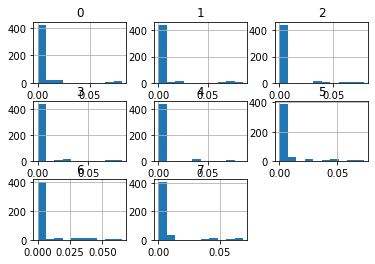

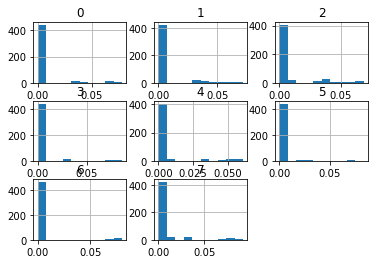

In [20]:
pd.DataFrame(W_false).describe()
pd.DataFrame(W_true).describe()
pd.DataFrame(W_false).hist()
pd.DataFrame(W_true).hist()

In [ ]:
"""
W = results_dict_new.get('loading')
# W = [(p x r) (words x topic), 1 x r (regression coeff. x topic)]
beta = W[1][0,1:r+1] ## first regression coefficient is for the constant term, so omit

idx_topic = np.argsort(beta)
idx_topic = np.flip(idx_topic)



for i in np.arange(W[0].shape[1]):
    idx_keyword = np.argsort(W[0][:,idx_topic[i]])
    idx_keyword = np.flip(idx_keyword)  
    
    ### Take top k keywords in each topic (top k coordinates in each column of W)
    ### to generate text data corresponding to the ith topic, and then generate its wordcloud
    list_words = []

    idx_keyword = np.argsort(W[0][:,idx_topic[i]])
    idx_keyword = np.flip(idx_keyword)   

    #for j in range(num_keywords_in_topic):
    #    list_words.append(idx2word[idx_keyword[j]])

    #Y = " ".join(list_words)
    
    print(beta[i])
    print('!! Y', df.columns[idx_keyword[0:10]])
"""